# Motivation

Being able to accurately forecast the volatile demand for power, especially across low-voltage distribution grids, is increasingly important to providing sufficent energy supply. Paradoxically, it's at the low-voltage networks that are the most volatile, and yet the most critical to account for as more distributed energy resources (e.g., solar, storage) make their way onto the grid. From the grid operator's point of view, not only are lower voltage service points (e.g., customers) the revenue life blood of the business, having increased visibility into demand at such lower levels of aggregation helps to provide 


In this notebook, I explore looking at a [Kaggle data set](https://www.kaggle.com/jeanmidev/smart-meters-in-london) containing about 5,000 utility service points with time series data from advanced metering infrastructure (AMI). The context of this experiment is to simulate the needs of a utility or grid operator and generate accurate short-term (up to 7 days ahead) forecast. I explore possible approaches that involve

- *Feature-based modeling approaches*
- *Customer Segmentation + Clustering*
- *Statistical methods, ML methods, and hybrid cross-learning approaches*

Performance is evaluated using time-series cross-validation using a rolling 7-day forecast horizon.

Finally, I show how this solution might be scaled and put into production.

Keywords: *time series classification*, *energy forecasting*, *cross-learning*, *MLOps*


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import os
from tqdm import tqdm

import keras
import tensorflow
#from tsfeatures import tsfeatures

Using TensorFlow backend.


In [2]:
# Set Project Working Directory
project_path = '/workspace/portfolio'

os.chdir(project_path)

# Set Data Path
data_path = f"{project_path}/data"
data_path

'/workspace/portfolio/data'

# Data

The data set we will use contains high-frequency measures of electricity demand usage across a panel of approximately 5,000 homes. It also contains customer metadata from the [ACORN](https://acorn.caci.co.uk/downloads/Acorn-User-guide.pdf) network, as well as atmospheric weather data from the DarkSky API (now owned by Apple and will be sunset by 2022).

In [3]:
# Process AMI Data
# The smart meter data is stored at the half-hour level of granularity in series of CSV files. 
# Here, we iterate over the files and concatenate into a single data frame in 'wide' format

ami_files = os.listdir(data_path + "/hhblock_dataset/hhblock_dataset/")

# Iterate over files using list comprehension
df_from_each_file = (pd.read_csv(data_path + "/hhblock_dataset/hhblock_dataset/" + f, sep=',') for f in ami_files)

df_merged   = pd.concat(df_from_each_file, ignore_index=True)
df_merged.head()


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000013,2012-06-22,0.127,0.113,0.076,0.109,0.120,0.096,0.113,0.148,...,0.086,0.154,0.121,0.102,0.131,0.121,0.082,0.096,0.127,0.126
1,MAC000013,2012-06-23,0.106,0.135,0.228,0.079,0.109,0.117,0.079,0.122,...,0.107,0.113,0.106,0.077,0.119,0.126,0.151,0.135,0.108,0.093
2,MAC000013,2012-06-25,0.099,0.119,0.169,0.136,0.109,0.090,0.132,0.131,...,0.140,0.135,0.134,0.106,0.131,0.169,0.170,0.141,0.163,0.137
3,MAC000013,2012-06-26,0.142,0.103,0.117,0.136,0.127,0.129,0.150,0.137,...,0.136,0.136,0.304,0.159,0.126,0.145,0.196,0.158,0.173,0.149
4,MAC000013,2012-06-27,0.126,0.128,0.175,0.163,0.119,0.103,0.128,0.141,...,0.170,0.144,0.098,0.183,0.316,0.190,0.121,0.176,0.158,0.146


In [4]:
# Process Hourly Weather Data
wthr = pd.read_csv(data_path + "/weather_hourly_darksky.csv")
wthr.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


<AxesSubplot:xlabel='time', ylabel='temperature'>

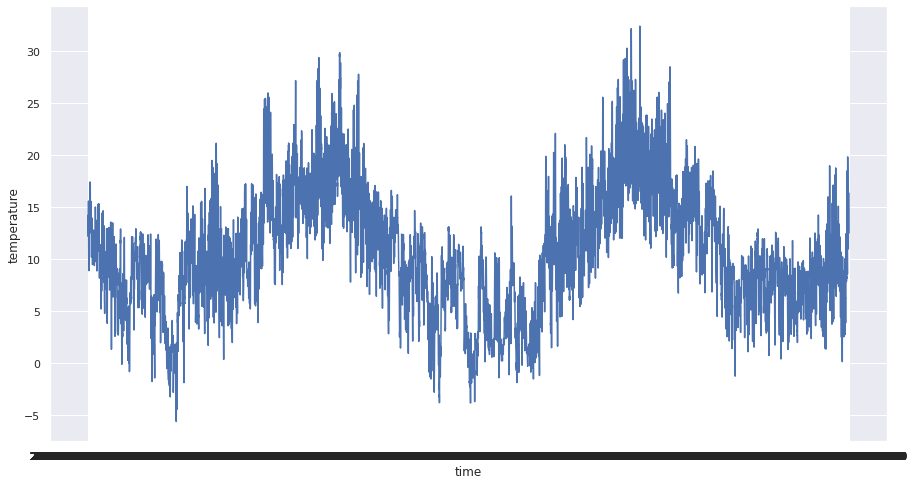

In [33]:
# Visualize Temperature Data
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data = wthr, x = "time", y = "temperature")


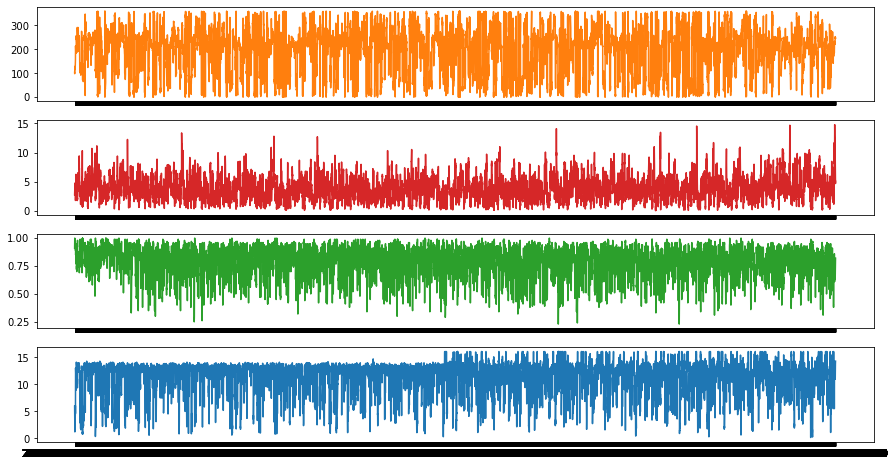

In [5]:
#sns.set(rc = {'figure.figsize':(8,8)})
plt.rcParams["figure.figsize"] = (15, 8)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True)
ax1.plot(wthr.time, wthr.windBearing, "tab:orange")
ax2.plot(wthr.time, wthr.windSpeed, "tab:red")
ax3.plot(wthr.time, wthr.humidity, "tab:green")
ax4.plot(wthr.time, wthr.visibility, "tab:blue")
#sns.lineplot(data = wthr, x = "time", y = "windBearing", ax = ax1, ci = None)
#sns.lineplot(data = wthr, x = "time", y = "windSpeed", ax = ax2, ci = None)
#sns.lineplot(data = wthr, x = "time", y = "humidity", ax = ax3, ci = None)
#sns.lineplot(data = wthr, x = "time", y = "visibility", ax = ax4, ci = None)

In [5]:
# Process Household Metadata
hh_info = pd.read_csv(data_path + "/acorn_details.csv", encoding = 'unicode_escape')
hh_info.head()
#hh_info['MAIN CATEGORIES'].value_counts()
#check = hh_info['REFERENCE'].unique

#
hh_info = pd.read_csv(data_path + "/informations_households.csv")
hh_info["Acorn"].value_counts()

ACORN-E    1567
ACORN-Q     831
ACORN-F     684
ACORN-H     455
ACORN-L     342
ACORN-D     292
ACORN-G     205
ACORN-K     165
ACORN-A     157
ACORN-N     152
ACORN-C     151
ACORN-M     113
ACORN-J     112
ACORN-P     110
ACORN-O     103
ACORN-I      51
ACORN-U      49
ACORN-B      25
ACORN-        2
Name: Acorn, dtype: int64

In [6]:
import gc
gc.collect()

42

In [7]:
# Unique Number of Sensor meters
ids = pd.DataFrame(df_merged['LCLid'].unique())
ids.columns = ['id']
ids.shape

(5560, 1)

# Feature Engineering

Many characteristics of time series can be useful in forecasting future realizations, and electricity time series is no different. While not technically referred to as "feature engineering", statisticians have been characterizing electricity time series for the better part of 50 years. These analysis typically fall under the title of "load research" and some common features might be the "peakiness" of the time series, and the overall magnitude. We can calcuate these statistics, per time series, and visualize them.

Here we use the `multiprocessing` library in Python do so aynchronously.

In [8]:
def calc_lr_stats(ids, df):
    '''function to subset ami data frame, create load research features based on set of ids'''
    
    # filter df based on ids
    df = df.loc[df['LCLid'].isin(ids["id"])]

    # pivot wide to long
    df = (pd.wide_to_long(df, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh")
        .sort_values(["day", "hh"])
        .reset_index())
    
    # reassign columns
    df.columns = ['ds', 'unique_id', 'hh', 'y']

    # drop NAs
    df = df[["ds", "unique_id", "y"]].dropna()
    
    # calculate features
    features = df.groupby(["unique_id"]).agg(["max", "mean"])
    
    #features = df.head()
    return pd.DataFrame(features)

ts = calc_lr_stats(ids = ids.sample(11), df = df_merged)
ts.head()

y          
             max      mean
unique_id                 
MAC000057  4.772  0.223660
MAC000232  0.736  0.052941
MAC000609  2.258  0.144763
MAC000949  4.949  0.247584
MAC000991  1.687  0.101977

In [29]:

batch_size = 1000  #chunk row size

# Use List Comprehension to create a list of data frame batches
list_df = [ids[i:i + batch_size] for i in range(0,ids.shape[0],batch_size)]

rs = []

for i in tqdm(list_df):
    try:
        rs.append(calc_lr_stats(i, df = df_merged))
    except:
        print("Failed to generate features")
    
    

100%|██████████| 6/6 [14:03<00:00, 140.54s/it]


In [16]:
# Using Spark
# - reference https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html
# - reference https://docs.faculty.ai/how_to/spark/local_spark.html
# - referemce https://spark.apache.org/docs/2.4.4/sql-pyspark-pandas-with-arrow.html

@pandas_udf("max double, mean double, unique_id string", PandasUDFType.GROUPED_MAP)
def calc_lr_stats_py(df):
    '''function to subset ami data frame, create load research features based on set of ids'''

    # pivot wide to long
    df = (pd.wide_to_long(df, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh")
        .sort_values(["day", "hh"])
        .reset_index())
    
    # reassign columns
    df.columns = ['ds', 'unique_id', 'hh', 'y']

    # drop NAs
    df = df[["ds", "unique_id", "y"]].dropna()
    
    # calculate features
    features = df.groupby(["unique_id"]).agg(["max", "mean"])
    features['unique_id'] = features.index
    
    #features = df.head()
    return pd.DataFrame(features)


In [80]:
df = df_merged.sample(100)

# pivot wide to long
df = (pd.wide_to_long(df, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh")
    .sort_values(["day", "hh"])
    .reset_index())

# reassign columns
df.columns = ['ds', 'unique_id', 'hh', 'y']

# drop NAs
df = df[["ds", "unique_id", "y"]].dropna()

# calculate features
features = df.groupby(["unique_id"]).agg(["max", "mean"])

features['unique_id'] = features.index

features.head()

y            unique_id
             max      mean           
unique_id                            
MAC000037  0.000  0.000000  MAC000037
MAC000045  2.181  0.384625  MAC000045
MAC000049  2.335  0.673833  MAC000049
MAC000078  0.048  0.025521  MAC000078
MAC000081  1.125  0.247042  MAC000081

In [23]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark

spark = SparkSession.builder \
         .master("local[*]") \
         .appName("energy-forecasting") \
         .config("spark.executor.memory", "5g") \
         .config("spark.executor.cores", 8) \
         .config("spark.deploy.defaultCores", 8) \
         .config("spark.driver.memory", "5g") \
         .config("spark.sql.execution.arrow.pyspark.enabled", True) \
         .getOrCreate()


In [22]:
spark.stop()

In [31]:
### Use Batch Processing and Pandas UDF in Spark to create Load Research Statistics ###

gc.collect()
batch_size = 1500  #chunk row size

# Use List Comprehension to create a list of data frame batches
list_df = [ids[i:i + batch_size] for i in range(0,ids.shape[0],batch_size)]

rs = []

for i in tqdm(list_df):
    try:
        local_df = df_merged.loc[df_merged['LCLid'].isin(i["id"])]
        spark_df = spark.createDataFrame(local_df)
        rs_df = spark_df.groupby('LCLid').apply(calc_lr_stats_py).collect().toPandas()
        rs.append(rs_df)

    except:
        print("Failed to generate features")
    
rs = pd.concat(rs)
    

  0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pyspark/sql/pandas/group_ops.py:84: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)
 25%|██▌       | 1/4 [00:41<02:04, 41.42s/it]

Failed to generate features


 50%|█████     | 2/4 [01:27<01:25, 42.76s/it]

Failed to generate features


 75%|███████▌  | 3/4 [01:31<00:31, 31.13s/it]

Failed to generate features


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59698)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1212, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
100%|██████████| 4/4 [01:32<00:00, 22.08s/it]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py

Failed to generate features


In [30]:
check = pd.concat(rs)
check.head()

,0,1,2
0,2.455,0.299435,MAC000925
1,2.489,0.163742,MAC000976
2,2.847,0.167852,MAC001761
3,1.315,0.095562,MAC004358
4,6.110,0.370343,MAC004897


In [ ]:
dflr.columns = ["max", "mean"]

from sklearn.cluster import KMeans

# K-means clustering
dflr["cluster"] = KMeans(n_clusters=3, random_state=0).fit_predict(dflr)
dflr["cluster"] = dflr["cluster"].astype(str)
dflr["cluster"].value_counts()

sns.scatterplot(data=dflr, x="mean", y="max", hue = dflr.cluster.tolist())


## Time Series Features

In addition to classic load research statistics, we can also borrow from other domains that analyze time series data for forecasting purposes. There has been significant research recently into time-series features, and an excellent R package for generating said features is [tsfeatures](https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html). Here we use a [Python implementation / API](https://github.com/Nixtla/tsfeatures) to the R package 

In [ ]:
def calc_features(ids, df):
    
    # filter df based on ids
    df = df.loc[df['LCLid'].isin(ids["id"])]

    # pivot wide to long
    df = (pd.wide_to_long(df, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh")
        .sort_values(["day", "hh"])
        .reset_index())
    
    # import time lookup
    #lookup = pd.read_csv(data_path + "/time-lookup.csv", sep = ",")

    df.columns = ['ds', 'unique_id', 'hh', 'y']

    df = df[["ds", "unique_id", "y"]].dropna()
    
    # calculate ts_features
    features = tsfeatures(df, freq = 1, features = [stl_features, acf_features, entropy])
    #features = df.head()
    return pd.DataFrame(features).drop(["hw_alpha", "hw_beta", "hw_gamma", "nperiods", "beta"], axis = 1)

check = calc_features(ids = ids.sample(11), df = df_merged)
check.head()

In [ ]:
from tqdm import tqdm

batch_size = 10  #chunk row size

# Use List Comprehension to create a list of data frame batches
list_df = [ids[i:i + batch_size] for i in range(0,ids.shape[0],batch_size)]

rs = []

for i in tqdm(list_df):
    print(i)
    try:
        rs.append(calc_features(i, df = df_merged))
    except:
        print("Failed to generate features")
    
    

# Energy Forecasting

In [ ]:
# - local models
# - local models with clusters
# - local 